# Reading Dataset , Cleaning, Preprocessing

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math  # Import the math module for perplexity calculation
import matplotlib.pyplot as plt 
import torch.nn.functional as F

# Replace 'train.csv' and 'test.csv' with the actual file paths to your CSV files.
train_csv_file = 'train.csv'
test_csv_file = 'test.csv'

# Read the training data from train.csv
train_data = pd.read_csv(train_csv_file)

# Read the test data from test.csv
test_data = pd.read_csv(test_csv_file)

# Split the dataset into train and development sets.
dev_set_size = 7600
train_set = train_data.iloc[dev_set_size:]  # The portion after the development set.
dev_set = train_data.iloc[:dev_set_size]    # The first 7600 entries as the development set.

# Extract sentences and labels for train, dev, and test sets.
train_sentences = train_set['Description'].tolist()
train_labels = train_set['Class Index'].tolist()

dev_sentences = dev_set['Description'].tolist()
dev_labels = dev_set['Class Index'].tolist()

test_sentences = test_data['Description'].tolist()
test_labels = test_data['Class Index'].tolist()

# Function to clean a sentence
def clean_sentence(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove special characters, numbers, and extra whitespace
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    # Tokenize the sentence (split into words)
    tokens = sentence.split()
    return ' '.join(tokens)

# Clean the sentences in the train, dev, and test sets
train_sentences_cleaned = [clean_sentence(sentence) for sentence in train_sentences]
dev_sentences_cleaned = [clean_sentence(sentence) for sentence in dev_sentences]
test_sentences_cleaned = [clean_sentence(sentence) for sentence in test_sentences]

# Tokenize the sentences using NLTK
nltk.download('punkt')
from nltk.tokenize import word_tokenize

train_sentences_tokenized = [word_tokenize(sentence) for sentence in train_sentences_cleaned]
dev_sentences_tokenized = [word_tokenize(sentence) for sentence in dev_sentences_cleaned]
test_sentences_tokenized = [word_tokenize(sentence) for sentence in test_sentences_cleaned]

# Define the maximum sequence length
max_seq_length = 256

# Function to pad sequences
def pad_sequences(sentences, max_length):
    padded_sentences = []
    for sentence in sentences:
        if len(sentence) >= max_length:
            padded_sentences.append(sentence[:max_length])
        else:
            padded_sentences.append(sentence + ['<PAD>'] * (max_length - len(sentence)))
    return padded_sentences

# Pad the sequences
train_sentences_padded = pad_sequences(train_sentences_tokenized, max_seq_length)
dev_sentences_padded = pad_sequences(dev_sentences_tokenized, max_seq_length)
test_sentences_padded = pad_sequences(test_sentences_tokenized, max_seq_length)

# Display the first few cleaned, tokenized, and padded sentences and labels for train, dev, and test sets.
print("Train Set Sentences (Padded):")
print(train_sentences_padded[:5])
print("Train Set Labels:")
print(train_labels[:5])

print("\nDevelopment Set Sentences (Padded):")
print(dev_sentences_padded[:5])
print("Development Set Labels:")
print(dev_labels[:5])

print("\nTest Set Sentences (Padded):")
print(test_sentences_padded[:5])
print("Test Set Labels:")
print(test_labels[:5])


[nltk_data] Downloading package punkt to /home/yash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Train Set Sentences (Padded):
[['such', 'an', 'embarrassment', 'of', 'riches', 'apple', 'macintosh', 'users', 'have', 'two', 'new', 'web', 'browsers', 'to', 'choose', 'from', 'it', 's', 'a', 'curious', 'market', 'all', 'macs', 'come', 'with', 'two', 'free', 'browsers', 'microsoft', 's', 'internet', 'explorer', 'and', 'apple', 's', 'own', 'slick', 'and', 'elegant', 'safari', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<

In [2]:
print(len(train_sentences_cleaned))
print(len(dev_sentences_cleaned))
print(len(test_sentences_cleaned))

112400
7600
7600


In [3]:
# Build vocabulary from the training set
all_words = [word for sentence in train_sentences_padded for word in sentence]
word_counts = Counter(all_words)

# Create word-to-index and index-to-word mappings
vocab = ['<UNK>'] + [word for word, count in word_counts.items()]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

# Function to convert a sentence to indices
def sentence_to_indices(sentence, word2idx):
    return [word2idx.get(word, word2idx['<UNK>']) for word in sentence]

# Convert train, dev, and test sets to index sequences : Pretrain
train_indices = [sentence_to_indices(sentence, word2idx) for sentence in train_sentences_tokenized]
dev_indices = [sentence_to_indices(sentence, word2idx) for sentence in dev_sentences_tokenized]
test_indices = [sentence_to_indices(sentence, word2idx) for sentence in test_sentences_tokenized]

# Convert train, dev, and test sets to index sequences : Sentiment Analysis
train_indices_elmo = [sentence_to_indices(sentence, word2idx) for sentence in train_sentences_padded]
dev_indices_elmo = [sentence_to_indices(sentence, word2idx) for sentence in dev_sentences_padded]
test_indices_elmo = [sentence_to_indices(sentence, word2idx) for sentence in test_sentences_padded]


# Display the first few sentences and labels for train, dev, and test sets in index form
print("Train Set Sentences (Indices):")
print(train_indices[:2])  # Displaying the first 2 sentences for brevity
print("Train Set Labels:")
print(train_labels[:2])

print("\nDevelopment Set Sentences (Indices):")
print(dev_indices[:2])
print("Development Set Labels:")
print(dev_labels[:2])

print("\nTest Set Sentences (Indices):")
print(test_indices[:2])
print("Test Set Labels:")
print(test_labels[:2])

# Display the first few sentences and labels for train, dev, and test sets in index form
print("Train Set Sentences (Indices):")
print(train_indices_elmo[:2])  # Displaying the first 2 sentences for brevity
print("Train Set Labels:")
print(train_labels[:2])

print("\nDevelopment Set Sentences (Indices):")
print(dev_indices_elmo[:2])
print("Development Set Labels:")
print(dev_labels[:2])

print("\nTest Set Sentences (Indices):")
print(test_indices_elmo[:2])
print("Test Set Labels:")
print(test_labels[:2])

Train Set Sentences (Indices):
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 10, 26, 13, 27, 18, 28, 29, 30, 6, 18, 31, 32, 30, 33, 34], [36, 37, 18, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 16, 36, 48, 30, 49, 4, 50, 51, 52, 53, 54, 55, 56]]
Train Set Labels:
[4, 2]

Development Set Sentences (Indices):
[[719, 0, 375, 1769, 0, 4, 0, 107, 4415, 4129, 501], [719, 5278, 392, 836, 54074, 0, 45, 19, 13240, 55, 541, 18021, 30, 0, 7356, 40, 36, 6338, 384, 45, 1391, 0, 6965, 68, 1255, 965, 4, 36, 21]]
Development Set Labels:
[3, 3]

Test Set Sentences (Indices):
[[8038, 1723, 160, 65, 8337, 18042, 608, 255, 107, 8738, 52, 631, 25, 10642, 6795, 836, 1286, 24472], [6460, 1600, 907, 19, 0, 4, 49529, 4917, 55, 36, 400, 41308, 9477, 8780, 19, 3858, 0, 9845, 43173, 2858, 4047, 45, 8846, 805, 36, 0, 4303, 55, 168, 20825, 17120]]
Test Set Labels:
[3, 4]
Train Set Sentences (Indices):
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,

In [4]:
# Concatenate all sentences into a single sequence
train_all_sentences = [idx for sentence in train_indices for idx in sentence]
dev_all_sentences = [idx for sentence in dev_indices for idx in sentence]
test_all_sentences = [idx for sentence in test_indices for idx in sentence]

# Function to create n-grams from a sequence of indices
def create_ngrams(sequence, n):
    ngrams = []
    for i in range(len(sequence) - n + 1):
        ngram = sequence[i:i + n]
        ngrams.append(ngram)
    return torch.tensor(ngrams)

# Create n-grams for train, dev, and test datasets
ngram_size = 6

train_ngrams = create_ngrams(train_all_sentences, ngram_size)
dev_ngrams = create_ngrams(dev_all_sentences, ngram_size)
test_ngrams = create_ngrams(test_all_sentences, ngram_size)

# Convert n-grams to PyTorch tensors
train_data = torch.tensor(train_ngrams, dtype=torch.long)
dev_data = torch.tensor(dev_ngrams, dtype=torch.long)
test_data = torch.tensor(test_ngrams, dtype=torch.long)

# Create DataLoader instances
batch_size = 32

# train_loader = DataLoader(TensorDataset(train_data[:10000]), batch_size=batch_size, shuffle=False)
# dev_loader = DataLoader(TensorDataset(dev_data[:500]), batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(TensorDataset(test_data[:500]), batch_size=batch_size, shuffle=False)

train_loader = DataLoader(TensorDataset(train_data[:100000]), batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(TensorDataset(dev_data[:5000]), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_data[:5000]), batch_size=batch_size, shuffle=False)



/tmp/ipykernel_9216/2443315753.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_ngrams, dtype=torch.long)
/tmp/ipykernel_9216/2443315753.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dev_data = torch.tensor(dev_ngrams, dtype=torch.long)
/tmp/ipykernel_9216/2443315753.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_ngrams, dtype=torch.long)


In [5]:
# for batch in train_loader:
#     # 'batch' is a tensor containing a batch of data
#     print(batch)
#     break

In [6]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# Load GloVe word vectors
def load_glove_model(file_path):
    word_vectors = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = [float(val) for val in values[1:]]
            word_vectors[word] = vector

    return word_vectors

glove_file_path = 'glove.6B.100d.txt'
glove_dict = load_glove_model(glove_file_path)

In [8]:
def create_embedding_matrix(glove_dict):
    '''
    Creates a weight matrix of the words that are common in the GloVe vocab and
    the dataset's vocab. Initializes OOV words with a zero vector.
    '''
    weights_matrix = torch.zeros((len(vocab), 100))
    words_found = 0
    for i, word in enumerate(vocab):
        try:
            weights_matrix[i] = torch.tensor(glove_dict[word])
            words_found += 1
        except:
            pass
        
    return weights_matrix, words_found


In [9]:
embedding_matrix, words_found = create_embedding_matrix(glove_dict)

In [10]:
words_found

50707

In [11]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, max_len, embedding_matrix, num_classes=4):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.max_len = max_len
        self.num_classes = num_classes

        # Shared Embedding Layer
        self.embedding1 = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding2 = nn.Embedding.from_pretrained(embedding_matrix)

        # Forward Language Model
        self.lstm_forward1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm_forward2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # Backward Language Model
        self.lstm_backward1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm_backward2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # Linear layer for mode 1
        self.linear_mode1 = nn.Linear(200, vocab_size)

        # Linear layer for mode 2
        self.linear_mode2 = nn.Linear(200, vocab_size)

        # Define trainable weights for mode 0 as a vector of size 3 with values 0.33 each
        self.weights_mode0 = nn.Parameter(torch.tensor([0.33, 0.33, 0.33], dtype=torch.float32))

        self.final_linear = nn.Linear(self.max_len * self.embedding_dim * 2, num_classes)

    def forward(self, input_data, mode):
        if mode == 0:
            # Embedding for forward data
            forward_embed = self.embedding1(input_data)

            # Embedding for backward data
            backward_embed = self.embedding2(input_data)

            # Forward Language Model 1
            forward_lstm1, _ = self.lstm_forward1(forward_embed)
            
            # Backward Language Model 1
            backward_lstm1, _ = self.lstm_backward1(backward_embed)
            
            # Concatenate forward1 and backward1 outputs
            lstm_concat1 = torch.cat((forward_lstm1, backward_lstm1), dim=-1)
            
            # Forward Language Model 2
            forward_lstm2, _ = self.lstm_forward2(forward_lstm1)
            
            # Backward Language Model 2
            backward_lstm2, _ = self.lstm_backward2(backward_lstm1)
            
            # Concatenate forward2 and backward2 outputs
            lstm_concat2 = torch.cat((forward_lstm2, backward_lstm2), dim=-1)

            # Concatenate forward and backward embeddings word by word
            concatenated_embeddings = torch.cat((forward_embed, backward_embed), dim=-1)
            
            # Apply trainable weights for mode 0 to the concatenated tensors
            weighted_embeddings = concatenated_embeddings * self.weights_mode0[0]
            weighted_lstm1 = lstm_concat1 * self.weights_mode0[1]
            weighted_lstm2 = lstm_concat2 * self.weights_mode0[2]

            # Sum along the last dimension (600) to get a (32 x 256 x 200) tensor
            summed_tensor = weighted_embeddings + weighted_lstm1 + weighted_lstm2

            # Reshape the output to 32 x (256 x vocabSize)
            output = summed_tensor.view(-1, self.max_len * self.embedding_dim *2)

            # Additional linear layer to reduce the output to 32 x 4
            output = self.final_linear(output)

            # output = F.softmax(output, dim=1)

            return output

        elif mode == 1:
            # Embedding for forward data
            forward_embed = self.embedding1(input_data)

            # Forward Language Model 1
            forward_lstm1, _ = self.lstm_forward1(forward_embed, None) # Set batch_first to False

            # Forward Language Model 2
            forward_lstm2, _ = self.lstm_forward2(forward_lstm1, None) # Set batch_first to False

            # Concatenate forward_lstm1 and forward_lstm2 outputs
            lstm_concat = torch.cat((forward_lstm1, forward_lstm2), dim=-1)

            # Apply linear layer for mode 1
            output = self.linear_mode1(lstm_concat)

            return output
        
        elif mode == 2:
            # Embedding for backward data
            backward_embed = self.embedding2(input_data)
            
            # Backward Language Model 1
            backward_lstm1, _ = self.lstm_backward1(backward_embed, None) # Set batch_first to False

            # Backward Language Model 2
            backward_lstm2, _ = self.lstm_backward2(backward_lstm1, None) # Set batch_first to False

            # Concatenate backward_lstm1 and backward_lstm2 outputs
            lstm_concat = torch.cat((backward_lstm1, backward_lstm2), dim=-1)

            # Apply linear layer for mode 2
            output = self.linear_mode2(lstm_concat)

            return output


In [12]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 100
max_len = 256
num_classes = 4

# Define the ELMo model
elmo = ELMo(vocab_size, embedding_dim, hidden_dim, batch_size, max_len, embedding_matrix, num_classes=num_classes)

# Move the model to the appropriate device (e.g., GPU)
elmo.to(device)

ELMo(
  (embedding1): Embedding(81098, 100)
  (embedding2): Embedding(81098, 100)
  (lstm_forward1): LSTM(100, 100, batch_first=True)
  (lstm_forward2): LSTM(100, 100, batch_first=True)
  (lstm_backward1): LSTM(100, 100, batch_first=True)
  (lstm_backward2): LSTM(100, 100, batch_first=True)
  (linear_mode1): Linear(in_features=200, out_features=81098, bias=True)
  (linear_mode2): Linear(in_features=200, out_features=81098, bias=True)
  (final_linear): Linear(in_features=51200, out_features=4, bias=True)
)

In [13]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(elmo.parameters(), lr=0.001)  # Adjust the learning rate as needed

# Training loop for mode 1 (next word prediction)
def train_mode1(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_tokens = 0  # Total tokens processed in the dataset

    for inputs in tqdm(train_loader):
        inputs = inputs[0]
        inputs = inputs.to(device)
        optimizer.zero_grad()

        # Use the first 5 words as input and the last 5 words as expected output
        input_seq = inputs[:, :5]
        target_seq = inputs[:, 1:]

        # Forward pass
        outputs = model(input_seq, mode=1)

        # Calculate the loss
        loss = criterion(outputs.permute(0, 2, 1), target_seq)  # Permute for CrossEntropyLoss
        total_loss += loss.item()

        # Calculate the total tokens processed
        total_tokens += target_seq.numel()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate perplexity based on the total loss and tokens
    perplexity = math.exp(total_loss / total_tokens)

    avg_loss = total_loss / total_tokens

    return avg_loss

# Development loop
def eval_mode1(model, dev_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0  # Total tokens processed in the dataset

    with torch.no_grad():
        for inputs in tqdm(dev_loader):
            inputs = inputs[0]
            inputs = inputs.to(device)

            # Use the first 5 words as input and the last 5 words as expected output
            input_seq = inputs[:, :5]
            target_seq = inputs[:, 1:]

            # Forward pass
            outputs = model(input_seq, mode=1)

            # Calculate the loss
            loss = criterion(outputs.permute(0, 2, 1), target_seq)  # Permute for CrossEntropyLoss
            total_loss += loss.item()

            # Calculate the total tokens processed
            total_tokens += target_seq.numel()

    avg_loss = total_loss / total_tokens

    return avg_loss

# Testing loop
def test_mode1(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0  # Total tokens processed in the dataset

    with torch.no_grad():
        for inputs in tqdm(test_loader):
            inputs = inputs[0]
            inputs = inputs.to(device)

            # Use the first 5 words as input and the last 5 words as expected output
            input_seq = inputs[:, :5]
            target_seq = inputs[:, 1:]

            # Forward pass
            outputs = model(input_seq, mode=1)

            # Calculate the loss
            loss = criterion(outputs.permute(0, 2, 1), target_seq)  # Permute for CrossEntropyLoss
            total_loss += loss.item()

            # Calculate the total tokens processed
            total_tokens += target_seq.numel()

    avg_loss = total_loss / total_tokens

    return avg_loss

# Training loop for mode 2 (previous word prediction)
def train_mode2(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_tokens = 0  # Total tokens processed in the dataset

    for inputs in tqdm(train_loader):
        inputs = inputs[0]
        inputs = inputs.to(device)
        optimizer.zero_grad()

        # Reversing inputs
        inputs = torch.flip(inputs, dims=[1])

        # Use the first 5 words as input and the last 5 words as expected output
        input_seq = inputs[:, :5]
        target_seq = inputs[:, 1:]

        # Forward pass
        outputs = model(input_seq, mode=2)

        # Calculate the loss
        loss = criterion(outputs.permute(0, 2, 1), target_seq)  # Permute for CrossEntropyLoss
        total_loss += loss.item()

        # Calculate the total tokens processed
        total_tokens += target_seq.numel()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / total_tokens

    return avg_loss

# Development loop
def eval_mode2(model, dev_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0  # Total tokens processed in the dataset

    with torch.no_grad():
        for inputs in tqdm(dev_loader):
            inputs = inputs[0]
            inputs = inputs.to(device)

            # Reversing inputs
            inputs = torch.flip(inputs, dims=[1])

            # Use the first 5 words as input and the last 5 words as expected output
            input_seq = inputs[:, :5]
            target_seq = inputs[:, 1:]

            # Forward pass
            outputs = model(input_seq, mode=2)

            # Calculate the loss
            loss = criterion(outputs.permute(0, 2, 1), target_seq)  # Permute for CrossEntropyLoss
            total_loss += loss.item()

            # Calculate the total tokens processed
            total_tokens += target_seq.numel()

    avg_loss = total_loss / total_tokens

    return avg_loss

# Testing loop
def test_mode2(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0  # Total tokens processed in the dataset

    with torch.no_grad():
        for inputs in tqdm(test_loader):
            inputs = inputs[0]
            inputs = inputs.to(device)

            # Reversing inputs
            inputs = torch.flip(inputs, dims=[1])

            # Use the first 5 words as input and the last 5 words as expected output
            input_seq = inputs[:, :5]
            target_seq = inputs[:, 1:]

            # Forward pass
            outputs = model(input_seq, mode=2)

            # Calculate the loss
            loss = criterion(outputs.permute(0, 2, 1), target_seq)  # Permute for CrossEntropyLoss
            total_loss += loss.item()

            # Calculate the total tokens processed
            total_tokens += target_seq.numel()

    avg_loss = total_loss / total_tokens

    return avg_loss


  0%|          | 0/3125 [00:00<?, ?it/s]

100%|██████████| 3125/3125 [00:38<00:00, 82.17it/s]


Epoch 1/15 (Mode 1) - Train Loss: 0.0469, Train Perplexity: 1.0480


100%|██████████| 157/157 [00:00<00:00, 343.39it/s]


Epoch 1/15 (Mode 1) - Dev Loss: 0.0481, Dev Perplexity: 1.0493


100%|██████████| 3125/3125 [00:36<00:00, 84.93it/s]


Epoch 2/15 (Mode 1) - Train Loss: 0.0372, Train Perplexity: 1.0379


100%|██████████| 157/157 [00:00<00:00, 346.29it/s]


Epoch 2/15 (Mode 1) - Dev Loss: 0.0490, Dev Perplexity: 1.0503


100%|██████████| 3125/3125 [00:36<00:00, 84.77it/s]


Epoch 3/15 (Mode 1) - Train Loss: 0.0325, Train Perplexity: 1.0331


100%|██████████| 157/157 [00:00<00:00, 306.78it/s]


Epoch 3/15 (Mode 1) - Dev Loss: 0.0514, Dev Perplexity: 1.0528


100%|██████████| 3125/3125 [00:39<00:00, 79.27it/s]


Epoch 4/15 (Mode 1) - Train Loss: 0.0292, Train Perplexity: 1.0297


100%|██████████| 157/157 [00:00<00:00, 305.75it/s]


Epoch 4/15 (Mode 1) - Dev Loss: 0.0535, Dev Perplexity: 1.0549


100%|██████████| 3125/3125 [00:41<00:00, 75.77it/s]


Epoch 5/15 (Mode 1) - Train Loss: 0.0268, Train Perplexity: 1.0271


100%|██████████| 157/157 [00:00<00:00, 301.29it/s]


Epoch 5/15 (Mode 1) - Dev Loss: 0.0548, Dev Perplexity: 1.0563


100%|██████████| 3125/3125 [00:37<00:00, 83.97it/s]


Epoch 6/15 (Mode 1) - Train Loss: 0.0249, Train Perplexity: 1.0252


100%|██████████| 157/157 [00:00<00:00, 301.81it/s]


Epoch 6/15 (Mode 1) - Dev Loss: 0.0559, Dev Perplexity: 1.0575


100%|██████████| 3125/3125 [00:40<00:00, 77.34it/s]


Epoch 7/15 (Mode 1) - Train Loss: 0.0234, Train Perplexity: 1.0237


100%|██████████| 157/157 [00:00<00:00, 337.87it/s]


Epoch 7/15 (Mode 1) - Dev Loss: 0.0568, Dev Perplexity: 1.0584


100%|██████████| 3125/3125 [00:37<00:00, 82.41it/s]


Epoch 8/15 (Mode 1) - Train Loss: 0.0222, Train Perplexity: 1.0224


100%|██████████| 157/157 [00:00<00:00, 305.53it/s]


Epoch 8/15 (Mode 1) - Dev Loss: 0.0576, Dev Perplexity: 1.0593


100%|██████████| 3125/3125 [00:38<00:00, 80.55it/s]


Epoch 9/15 (Mode 1) - Train Loss: 0.0212, Train Perplexity: 1.0214


100%|██████████| 157/157 [00:00<00:00, 335.29it/s]


Epoch 9/15 (Mode 1) - Dev Loss: 0.0582, Dev Perplexity: 1.0600


100%|██████████| 3125/3125 [00:36<00:00, 86.30it/s]


Epoch 10/15 (Mode 1) - Train Loss: 0.0203, Train Perplexity: 1.0205


100%|██████████| 157/157 [00:00<00:00, 344.29it/s]


Epoch 10/15 (Mode 1) - Dev Loss: 0.0589, Dev Perplexity: 1.0606


100%|██████████| 3125/3125 [00:35<00:00, 86.82it/s]


Epoch 11/15 (Mode 1) - Train Loss: 0.0196, Train Perplexity: 1.0198


100%|██████████| 157/157 [00:00<00:00, 356.35it/s]


Epoch 11/15 (Mode 1) - Dev Loss: 0.0594, Dev Perplexity: 1.0612


100%|██████████| 3125/3125 [00:36<00:00, 84.83it/s]


Epoch 12/15 (Mode 1) - Train Loss: 0.0189, Train Perplexity: 1.0191


100%|██████████| 157/157 [00:00<00:00, 330.24it/s]


Epoch 12/15 (Mode 1) - Dev Loss: 0.0600, Dev Perplexity: 1.0618


100%|██████████| 3125/3125 [00:37<00:00, 82.83it/s]


Epoch 13/15 (Mode 1) - Train Loss: 0.0184, Train Perplexity: 1.0186


100%|██████████| 157/157 [00:00<00:00, 346.92it/s]


Epoch 13/15 (Mode 1) - Dev Loss: 0.0605, Dev Perplexity: 1.0624


100%|██████████| 3125/3125 [00:35<00:00, 88.50it/s]


Epoch 14/15 (Mode 1) - Train Loss: 0.0179, Train Perplexity: 1.0181


100%|██████████| 157/157 [00:00<00:00, 366.94it/s]


Epoch 14/15 (Mode 1) - Dev Loss: 0.0610, Dev Perplexity: 1.0629


100%|██████████| 3125/3125 [00:37<00:00, 84.02it/s]


Epoch 15/15 (Mode 1) - Train Loss: 0.0175, Train Perplexity: 1.0176


100%|██████████| 157/157 [00:00<00:00, 327.37it/s]


Epoch 15/15 (Mode 1) - Dev Loss: 0.0616, Dev Perplexity: 1.0635


100%|██████████| 3125/3125 [00:36<00:00, 85.63it/s]


Epoch 1/15 (Mode 2) - Train Loss: 0.0468, Train Perplexity: 1.0479


100%|██████████| 157/157 [00:00<00:00, 345.91it/s]


Epoch 1/15 (Mode 2) - Dev Loss: 0.0478, Dev Perplexity: 1.0490


100%|██████████| 3125/3125 [00:36<00:00, 86.27it/s]


Epoch 2/15 (Mode 2) - Train Loss: 0.0370, Train Perplexity: 1.0377


100%|██████████| 157/157 [00:00<00:00, 365.67it/s]


Epoch 2/15 (Mode 2) - Dev Loss: 0.0494, Dev Perplexity: 1.0506


100%|██████████| 3125/3125 [00:34<00:00, 89.47it/s]


Epoch 3/15 (Mode 2) - Train Loss: 0.0322, Train Perplexity: 1.0328


100%|██████████| 157/157 [00:00<00:00, 350.78it/s]


Epoch 3/15 (Mode 2) - Dev Loss: 0.0520, Dev Perplexity: 1.0533


100%|██████████| 3125/3125 [00:39<00:00, 80.00it/s]


Epoch 4/15 (Mode 2) - Train Loss: 0.0289, Train Perplexity: 1.0293


100%|██████████| 157/157 [00:00<00:00, 317.16it/s]


Epoch 4/15 (Mode 2) - Dev Loss: 0.0542, Dev Perplexity: 1.0557


100%|██████████| 3125/3125 [00:37<00:00, 82.91it/s]


Epoch 5/15 (Mode 2) - Train Loss: 0.0264, Train Perplexity: 1.0268


100%|██████████| 157/157 [00:00<00:00, 317.92it/s]


Epoch 5/15 (Mode 2) - Dev Loss: 0.0556, Dev Perplexity: 1.0572


100%|██████████| 3125/3125 [00:36<00:00, 86.51it/s]


Epoch 6/15 (Mode 2) - Train Loss: 0.0245, Train Perplexity: 1.0249


100%|██████████| 157/157 [00:00<00:00, 358.35it/s]


Epoch 6/15 (Mode 2) - Dev Loss: 0.0568, Dev Perplexity: 1.0584


100%|██████████| 3125/3125 [00:36<00:00, 86.28it/s]


Epoch 7/15 (Mode 2) - Train Loss: 0.0231, Train Perplexity: 1.0233


100%|██████████| 157/157 [00:00<00:00, 308.54it/s]


Epoch 7/15 (Mode 2) - Dev Loss: 0.0577, Dev Perplexity: 1.0594


100%|██████████| 3125/3125 [00:37<00:00, 82.34it/s]


Epoch 8/15 (Mode 2) - Train Loss: 0.0219, Train Perplexity: 1.0221


100%|██████████| 157/157 [00:00<00:00, 332.74it/s]


Epoch 8/15 (Mode 2) - Dev Loss: 0.0586, Dev Perplexity: 1.0603


100%|██████████| 3125/3125 [00:36<00:00, 86.21it/s]


Epoch 9/15 (Mode 2) - Train Loss: 0.0209, Train Perplexity: 1.0211


100%|██████████| 157/157 [00:00<00:00, 325.23it/s]


Epoch 9/15 (Mode 2) - Dev Loss: 0.0593, Dev Perplexity: 1.0611


100%|██████████| 3125/3125 [00:36<00:00, 86.09it/s]


Epoch 10/15 (Mode 2) - Train Loss: 0.0200, Train Perplexity: 1.0202


100%|██████████| 157/157 [00:00<00:00, 332.72it/s]


Epoch 10/15 (Mode 2) - Dev Loss: 0.0600, Dev Perplexity: 1.0619


100%|██████████| 3125/3125 [00:36<00:00, 85.32it/s]


Epoch 11/15 (Mode 2) - Train Loss: 0.0193, Train Perplexity: 1.0195


100%|██████████| 157/157 [00:00<00:00, 352.58it/s]


Epoch 11/15 (Mode 2) - Dev Loss: 0.0607, Dev Perplexity: 1.0626


100%|██████████| 3125/3125 [00:36<00:00, 85.75it/s]


Epoch 12/15 (Mode 2) - Train Loss: 0.0186, Train Perplexity: 1.0188


100%|██████████| 157/157 [00:00<00:00, 302.39it/s]


Epoch 12/15 (Mode 2) - Dev Loss: 0.0613, Dev Perplexity: 1.0632


100%|██████████| 3125/3125 [00:39<00:00, 78.60it/s]


Epoch 13/15 (Mode 2) - Train Loss: 0.0181, Train Perplexity: 1.0182


100%|██████████| 157/157 [00:00<00:00, 301.60it/s]


Epoch 13/15 (Mode 2) - Dev Loss: 0.0619, Dev Perplexity: 1.0638


100%|██████████| 3125/3125 [00:37<00:00, 83.51it/s]


Epoch 14/15 (Mode 2) - Train Loss: 0.0176, Train Perplexity: 1.0177


100%|██████████| 157/157 [00:00<00:00, 364.00it/s]


Epoch 14/15 (Mode 2) - Dev Loss: 0.0624, Dev Perplexity: 1.0644


100%|██████████| 3125/3125 [00:36<00:00, 86.22it/s]


Epoch 15/15 (Mode 2) - Train Loss: 0.0171, Train Perplexity: 1.0173


100%|██████████| 157/157 [00:00<00:00, 364.75it/s]


Epoch 15/15 (Mode 2) - Dev Loss: 0.0630, Dev Perplexity: 1.0650


100%|██████████| 157/157 [00:00<00:00, 371.35it/s]


Test Loss (Mode 1): 0.0580, Test Perplexity (Mode 1): 1.0597
Test Loss (Mode 2): 0.0588, Test Perplexity (Mode 2): 1.0606


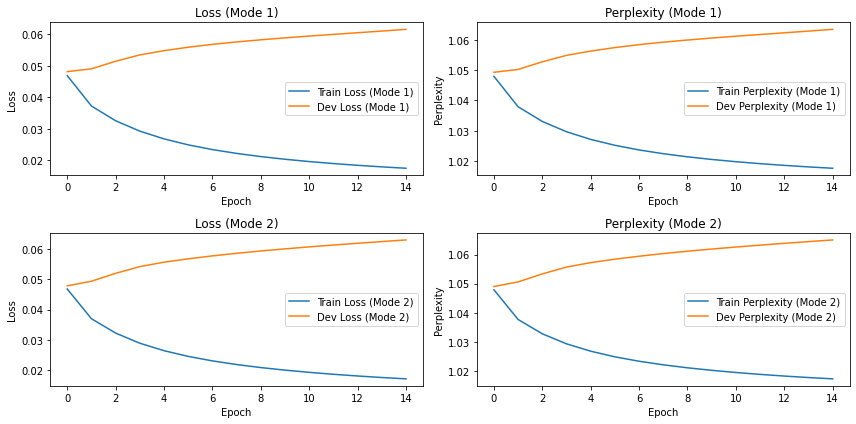

Test Loss (Mode 1): 0.0580, Test Perplexity (Mode 1): 1.0597
Test Loss (Mode 2): 0.0588, Test Perplexity (Mode 2): 1.0606


In [14]:
# Training hyperparameters
num_epochs = 15  # Adjust as needed

# Initialize empty lists to store loss and perplexity values
loss_mode1_values = []
perplexity_mode1_values = []
loss_mode2_values = []
perplexity_mode2_values = []
dev_loss_mode1_values = []  # To store dev loss
dev_perplexity_mode1_values = []  # To store dev perplexity
dev_loss_mode2_values = []  # To store dev loss
dev_perplexity_mode2_values = []  # To store dev perplexity
test_loss_mode1_values = []  # To store test loss
test_perplexity_mode1_values = []  # To store test perplexity
test_loss_mode2_values = []  # To store test loss
test_perplexity_mode2_values = []  # To store test perplexity

# Training loop for mode 1
for epoch in range(num_epochs):
    train_loss_mode1 = train_mode1(elmo, train_loader, optimizer, criterion, device)
    loss_mode1_values.append(train_loss_mode1)

    # Calculate perplexity based on the loss (assuming cross-entropy loss)
    perplexity_mode1 = math.exp(train_loss_mode1)
    perplexity_mode1_values.append(perplexity_mode1)

    print(f"Epoch {epoch+1}/{num_epochs} (Mode 1) - Train Loss: {train_loss_mode1:.4f}, Train Perplexity: {perplexity_mode1:.4f}")

    # Evaluate on dev dataset
    dev_loss_mode1 = eval_mode1(elmo, dev_loader, criterion, device)
    dev_loss_mode1_values.append(dev_loss_mode1)

    # Calculate perplexity based on the dev loss (assuming cross-entropy loss)
    dev_perplexity_mode1 = math.exp(dev_loss_mode1)
    dev_perplexity_mode1_values.append(dev_perplexity_mode1)

    print(f"Epoch {epoch+1}/{num_epochs} (Mode 1) - Dev Loss: {dev_loss_mode1:.4f}, Dev Perplexity: {dev_perplexity_mode1:.4f}")

# Training loop for mode 2
for epoch in range(num_epochs):
    train_loss_mode2 = train_mode2(elmo, train_loader, optimizer, criterion, device)
    loss_mode2_values.append(train_loss_mode2)

    # Calculate perplexity based on the loss (assuming cross-entropy loss)
    perplexity_mode2 = math.exp(train_loss_mode2)
    perplexity_mode2_values.append(perplexity_mode2)

    print(f"Epoch {epoch+1}/{num_epochs} (Mode 2) - Train Loss: {train_loss_mode2:.4f}, Train Perplexity: {perplexity_mode2:.4f}")

    # Evaluate on dev dataset
    dev_loss_mode2 = eval_mode2(elmo, dev_loader, criterion, device)
    dev_loss_mode2_values.append(dev_loss_mode2)

    # Calculate perplexity based on the dev loss (assuming cross-entropy loss)
    dev_perplexity_mode2 = math.exp(dev_loss_mode2)
    dev_perplexity_mode2_values.append(dev_perplexity_mode2)

    print(f"Epoch {epoch+1}/{num_epochs} (Mode 2) - Dev Loss: {dev_loss_mode2:.4f}, Dev Perplexity: {dev_perplexity_mode2:.4f}")

# Testing loop
test_loss_mode1 = test_mode1(elmo, test_loader, criterion, device)
test_loss_mode2 = test_mode2(elmo, test_loader, criterion, device)

# Calculate perplexity based on the test loss (assuming cross-entropy loss)
test_perplexity_mode1 = math.exp(test_loss_mode1)
test_perplexity_mode2 = math.exp(test_loss_mode2)

# Store test results
test_loss_mode1_values.append(test_loss_mode1)
test_perplexity_mode1_values.append(test_perplexity_mode1)
test_loss_mode2_values.append(test_loss_mode2)
test_perplexity_mode2_values.append(test_perplexity_mode2)

print(f"Test Loss (Mode 1): {test_loss_mode1:.4f}, Test Perplexity (Mode 1): {test_perplexity_mode1:.4f}")
print(f"Test Loss (Mode 2): {test_loss_mode2:.4f}, Test Perplexity (Mode 2): {test_perplexity_mode2:.4f}")

# Plotting loss and perplexity graphs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loss plot for Mode 1
plt.subplot(2, 2, 1)
plt.plot(range(num_epochs), loss_mode1_values, label="Train Loss (Mode 1)")
plt.plot(range(num_epochs), dev_loss_mode1_values, label="Dev Loss (Mode 1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Mode 1)")
plt.legend()

# Perplexity plot for Mode 1
plt.subplot(2, 2, 2)
plt.plot(range(num_epochs), perplexity_mode1_values, label="Train Perplexity (Mode 1)")
plt.plot(range(num_epochs), dev_perplexity_mode1_values, label="Dev Perplexity (Mode 1)")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity (Mode 1)")
plt.legend()

# Loss plot for Mode 2
plt.subplot(2, 2, 3)
plt.plot(range(num_epochs), loss_mode2_values, label="Train Loss (Mode 2)")
plt.plot(range(num_epochs), dev_loss_mode2_values, label="Dev Loss (Mode 2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Mode 2)")
plt.legend()

# Perplexity plot for Mode 2
plt.subplot(2, 2, 4)
plt.plot(range(num_epochs), perplexity_mode2_values, label="Train Perplexity (Mode 2)")
plt.plot(range(num_epochs), dev_perplexity_mode2_values, label="Dev Perplexity (Mode 2)")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity (Mode 2)")
plt.legend()

plt.tight_layout()
plt.show()

# Display test results
print(f"Test Loss (Mode 1): {test_loss_mode1:.4f}, Test Perplexity (Mode 1): {test_perplexity_mode1:.4f}")
print(f"Test Loss (Mode 2): {test_loss_mode2:.4f}, Test Perplexity (Mode 2): {test_perplexity_mode2:.4f}")


# Saving Pretrained Model

In [15]:
# Save the model to a file
torch.save(elmo.state_dict(), 'elmo_Pretrain.pth')

# Loading Pretrained Parameters

In [16]:
# Load the pretrained model state
elmo.load_state_dict(torch.load('elmo_Pretrain.pth', map_location=device))  # 'device' should be set to the appropriate device

# Move the loaded model to the appropriate device
elmo.to(device)


ELMo(
  (embedding1): Embedding(81098, 100)
  (embedding2): Embedding(81098, 100)
  (lstm_forward1): LSTM(100, 100, batch_first=True)
  (lstm_forward2): LSTM(100, 100, batch_first=True)
  (lstm_backward1): LSTM(100, 100, batch_first=True)
  (lstm_backward2): LSTM(100, 100, batch_first=True)
  (linear_mode1): Linear(in_features=200, out_features=81098, bias=True)
  (linear_mode2): Linear(in_features=200, out_features=81098, bias=True)
  (final_linear): Linear(in_features=51200, out_features=4, bias=True)
)

# Some Preprocessing

In [17]:
# Convert n-grams to PyTorch tensors
train_data_elmo = torch.tensor(train_indices_elmo, dtype=torch.long)
dev_data_elmo = torch.tensor(dev_indices_elmo, dtype=torch.long)
test_data_elmo = torch.tensor(test_indices_elmo, dtype=torch.long)

# # Combine data with labels
# train_data_with_labels = TensorDataset(train_data_elmo[:10000], torch.tensor(train_labels[:10000], dtype=torch.long))
# dev_data_with_labels = TensorDataset(dev_data_elmo[:500], torch.tensor(dev_labels[:500], dtype=torch.long))
# test_data_with_labels = TensorDataset(test_data_elmo[:500], torch.tensor(test_labels[:500], dtype=torch.long))

# Combine data with labels
train_data_with_labels = TensorDataset(train_data_elmo[:100000], torch.tensor(train_labels[:100000], dtype=torch.long))
dev_data_with_labels = TensorDataset(dev_data_elmo[:5000], torch.tensor(dev_labels[:5000], dtype=torch.long))
test_data_with_labels = TensorDataset(test_data_elmo[:5000], torch.tensor(test_labels[:5000], dtype=torch.long))

# Create DataLoader instances
batch_size = 32

train_loader = DataLoader(train_data_with_labels, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_data_with_labels, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_with_labels, batch_size=batch_size, shuffle=False)

In [18]:
# Display the first few sentences and labels for train, dev, and test sets in index form
print("Train Set Sentences (Indices):")
print(train_indices_elmo[:2])  # Displaying the first 2 sentences for brevity
print("Train Set Labels:")
print(train_labels[:2])

print("\nDevelopment Set Sentences (Indices):")
print(dev_indices_elmo[:2])
print("Development Set Labels:")
print(dev_labels[:2])

print("\nTest Set Sentences (Indices):")
print(test_indices_elmo[:2])
print("Test Set Labels:")
print(test_labels[:2])

Train Set Sentences (Indices):
[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 10, 26, 13, 27, 18, 28, 29, 30, 6, 18, 31, 32, 30, 33, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 3

In [19]:
# Training loop for mode 0 (4-class classification) on GPU
def train_elmo(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    all_predicted = []
    all_actual = []

    for inputs, target_seq in tqdm(train_loader):
        inputs = inputs.to(device)
        target_seq = target_seq.to(device)
        optimizer.zero_grad()

        input_seq = inputs

        # Forward pass
        outputs = model(input_seq, mode=0)

        target_seq = target_seq - 1

        # Calculate the loss directly with integer class labels
        loss = criterion(outputs, target_seq)
        total_loss += loss.item()

        # Calculate correct predictions
        predicted_classes = torch.argmax(outputs, dim=1)
        correct_predictions = torch.sum(torch.eq(predicted_classes, target_seq))
        total_correct += correct_predictions.item()

        all_predicted.extend(predicted_classes.cpu().numpy())
        all_actual.extend(target_seq.cpu().numpy())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    accuracy = total_correct / len(all_actual)  # Calculate accuracy based on the entire dataset

    return total_loss / len(train_loader), accuracy, all_predicted, all_actual

# Evaluation loop for mode 0 (4-class classification) on GPU
def evaluate_elmo(model, dev_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    all_predicted = []
    all_actual = []

    with torch.no_grad():
        for inputs, target_seq in tqdm(dev_loader):
            inputs = inputs.to(device)
            target_seq = target_seq.to(device)

            input_seq = inputs

            # Forward pass
            outputs = model(input_seq, mode=0)

            target_seq = target_seq - 1

            # Calculate the loss directly with integer class labels
            loss = criterion(outputs, target_seq)
            total_loss += loss.item()

            # Calculate correct predictions
            predicted_classes = torch.argmax(outputs, dim=1)
            correct_predictions = torch.sum(torch.eq(predicted_classes, target_seq))
            total_correct += correct_predictions.item()

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_actual.extend(target_seq.cpu().numpy())

    accuracy = total_correct / len(all_actual)  # Calculate accuracy based on the entire dataset

    return total_loss / len(dev_loader), accuracy, all_predicted, all_actual


# Test loop for mode 0 (4-class classification) on GPU
def evaluate_elmo(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    all_predicted = []
    all_actual = []

    with torch.no_grad():
        for inputs, target_seq in tqdm(test_loader):
            inputs = inputs.to(device)
            target_seq = target_seq.to(device)

            input_seq = inputs

            # Forward pass
            outputs = model(input_seq, mode=0)

            target_seq = target_seq - 1

            # Calculate the loss directly with integer class labels
            loss = criterion(outputs, target_seq)
            total_loss += loss.item()

            # Calculate correct predictions
            predicted_classes = torch.argmax(outputs, dim=1)
            correct_predictions = torch.sum(torch.eq(predicted_classes, target_seq))
            total_correct += correct_predictions.item()

            all_predicted.extend(predicted_classes.cpu().numpy())
            all_actual.extend(target_seq.cpu().numpy())

    accuracy = total_correct / len(all_actual)  # Calculate accuracy based on the entire dataset

    return total_loss / len(test_loader), accuracy, all_predicted, all_actual

  0%|          | 0/3125 [00:00<?, ?it/s]

100%|██████████| 3125/3125 [00:35<00:00, 88.83it/s]


Epoch 1/15 (Train) - Loss: 0.3831, Accuracy: 86.50%, Precision: 0.8649, Recall: 0.8650, Micro F1 Score: 0.8650


100%|██████████| 157/157 [00:00<00:00, 215.59it/s]


Epoch 1/15 (Dev) - Loss: 0.4421, Accuracy: 85.64%, Precision: 0.8577, Recall: 0.8564, Micro F1 Score: 0.8564


100%|██████████| 3125/3125 [00:35<00:00, 88.24it/s]


Epoch 2/15 (Train) - Loss: 0.2762, Accuracy: 90.21%, Precision: 0.9021, Recall: 0.9021, Micro F1 Score: 0.9021


100%|██████████| 157/157 [00:00<00:00, 221.26it/s]


Epoch 2/15 (Dev) - Loss: 0.4199, Accuracy: 86.72%, Precision: 0.8687, Recall: 0.8672, Micro F1 Score: 0.8672


100%|██████████| 3125/3125 [00:35<00:00, 88.72it/s]


Epoch 3/15 (Train) - Loss: 0.2272, Accuracy: 91.97%, Precision: 0.9198, Recall: 0.9197, Micro F1 Score: 0.9197


100%|██████████| 157/157 [00:00<00:00, 213.29it/s]


Epoch 3/15 (Dev) - Loss: 0.4214, Accuracy: 86.66%, Precision: 0.8672, Recall: 0.8666, Micro F1 Score: 0.8666


100%|██████████| 3125/3125 [00:35<00:00, 88.29it/s]


Epoch 4/15 (Train) - Loss: 0.1783, Accuracy: 93.85%, Precision: 0.9386, Recall: 0.9385, Micro F1 Score: 0.9385


100%|██████████| 157/157 [00:00<00:00, 217.62it/s]


Epoch 4/15 (Dev) - Loss: 0.4774, Accuracy: 86.16%, Precision: 0.8616, Recall: 0.8616, Micro F1 Score: 0.8616


100%|██████████| 3125/3125 [00:34<00:00, 90.33it/s]


Epoch 5/15 (Train) - Loss: 0.1390, Accuracy: 95.18%, Precision: 0.9519, Recall: 0.9518, Micro F1 Score: 0.9518


100%|██████████| 157/157 [00:00<00:00, 169.07it/s]


Epoch 5/15 (Dev) - Loss: 0.5370, Accuracy: 86.56%, Precision: 0.8658, Recall: 0.8656, Micro F1 Score: 0.8656


100%|██████████| 3125/3125 [00:36<00:00, 86.19it/s]


Epoch 6/15 (Train) - Loss: 0.1111, Accuracy: 96.09%, Precision: 0.9610, Recall: 0.9609, Micro F1 Score: 0.9609


100%|██████████| 157/157 [00:00<00:00, 196.01it/s]


Epoch 6/15 (Dev) - Loss: 0.6037, Accuracy: 85.82%, Precision: 0.8582, Recall: 0.8582, Micro F1 Score: 0.8582


100%|██████████| 3125/3125 [00:37<00:00, 84.32it/s]


Epoch 7/15 (Train) - Loss: 0.0894, Accuracy: 96.83%, Precision: 0.9683, Recall: 0.9683, Micro F1 Score: 0.9683


100%|██████████| 157/157 [00:00<00:00, 215.59it/s]


Epoch 7/15 (Dev) - Loss: 0.6781, Accuracy: 85.60%, Precision: 0.8562, Recall: 0.8560, Micro F1 Score: 0.8560


100%|██████████| 3125/3125 [00:36<00:00, 85.98it/s]


Epoch 8/15 (Train) - Loss: 0.0804, Accuracy: 97.17%, Precision: 0.9717, Recall: 0.9717, Micro F1 Score: 0.9717


100%|██████████| 157/157 [00:00<00:00, 205.63it/s]


Epoch 8/15 (Dev) - Loss: 0.7412, Accuracy: 85.56%, Precision: 0.8573, Recall: 0.8556, Micro F1 Score: 0.8556


100%|██████████| 3125/3125 [00:36<00:00, 85.46it/s] 


Epoch 9/15 (Train) - Loss: 0.0734, Accuracy: 97.40%, Precision: 0.9740, Recall: 0.9740, Micro F1 Score: 0.9740


100%|██████████| 157/157 [00:00<00:00, 214.43it/s]


Epoch 9/15 (Dev) - Loss: 0.7533, Accuracy: 86.10%, Precision: 0.8606, Recall: 0.8610, Micro F1 Score: 0.8610


100%|██████████| 3125/3125 [00:37<00:00, 83.98it/s]


Epoch 10/15 (Train) - Loss: 0.0666, Accuracy: 97.63%, Precision: 0.9763, Recall: 0.9763, Micro F1 Score: 0.9763


100%|██████████| 157/157 [00:00<00:00, 215.97it/s]


Epoch 10/15 (Dev) - Loss: 0.7762, Accuracy: 85.58%, Precision: 0.8566, Recall: 0.8558, Micro F1 Score: 0.8558


100%|██████████| 3125/3125 [00:36<00:00, 85.76it/s]


Epoch 11/15 (Train) - Loss: 0.0619, Accuracy: 97.86%, Precision: 0.9786, Recall: 0.9786, Micro F1 Score: 0.9786


100%|██████████| 157/157 [00:00<00:00, 165.91it/s]


Epoch 11/15 (Dev) - Loss: 0.8403, Accuracy: 85.80%, Precision: 0.8592, Recall: 0.8580, Micro F1 Score: 0.8580


100%|██████████| 3125/3125 [00:37<00:00, 83.66it/s]


Epoch 12/15 (Train) - Loss: 0.0581, Accuracy: 97.98%, Precision: 0.9798, Recall: 0.9798, Micro F1 Score: 0.9798


100%|██████████| 157/157 [00:00<00:00, 210.55it/s]


Epoch 12/15 (Dev) - Loss: 0.8315, Accuracy: 86.62%, Precision: 0.8659, Recall: 0.8662, Micro F1 Score: 0.8662


100%|██████████| 3125/3125 [00:36<00:00, 84.93it/s]


Epoch 13/15 (Train) - Loss: 0.0569, Accuracy: 98.07%, Precision: 0.9807, Recall: 0.9807, Micro F1 Score: 0.9807


100%|██████████| 157/157 [00:00<00:00, 181.18it/s]


Epoch 13/15 (Dev) - Loss: 0.8894, Accuracy: 86.06%, Precision: 0.8612, Recall: 0.8606, Micro F1 Score: 0.8606


100%|██████████| 3125/3125 [00:35<00:00, 87.24it/s]


Epoch 14/15 (Train) - Loss: 0.0546, Accuracy: 98.11%, Precision: 0.9811, Recall: 0.9811, Micro F1 Score: 0.9811


100%|██████████| 157/157 [00:00<00:00, 184.37it/s]


Epoch 14/15 (Dev) - Loss: 0.8498, Accuracy: 86.02%, Precision: 0.8600, Recall: 0.8602, Micro F1 Score: 0.8602


100%|██████████| 3125/3125 [00:36<00:00, 85.43it/s]


Epoch 15/15 (Train) - Loss: 0.0527, Accuracy: 98.22%, Precision: 0.9822, Recall: 0.9822, Micro F1 Score: 0.9822


100%|██████████| 157/157 [00:00<00:00, 215.52it/s]


Epoch 15/15 (Dev) - Loss: 0.8276, Accuracy: 86.22%, Precision: 0.8624, Recall: 0.8622, Micro F1 Score: 0.8622


100%|██████████| 157/157 [00:00<00:00, 214.95it/s]


Test Loss: 0.6161, Test Accuracy: 88.98%, Precision: 0.8898, Recall: 0.8898, Micro F1 Score: 0.8898


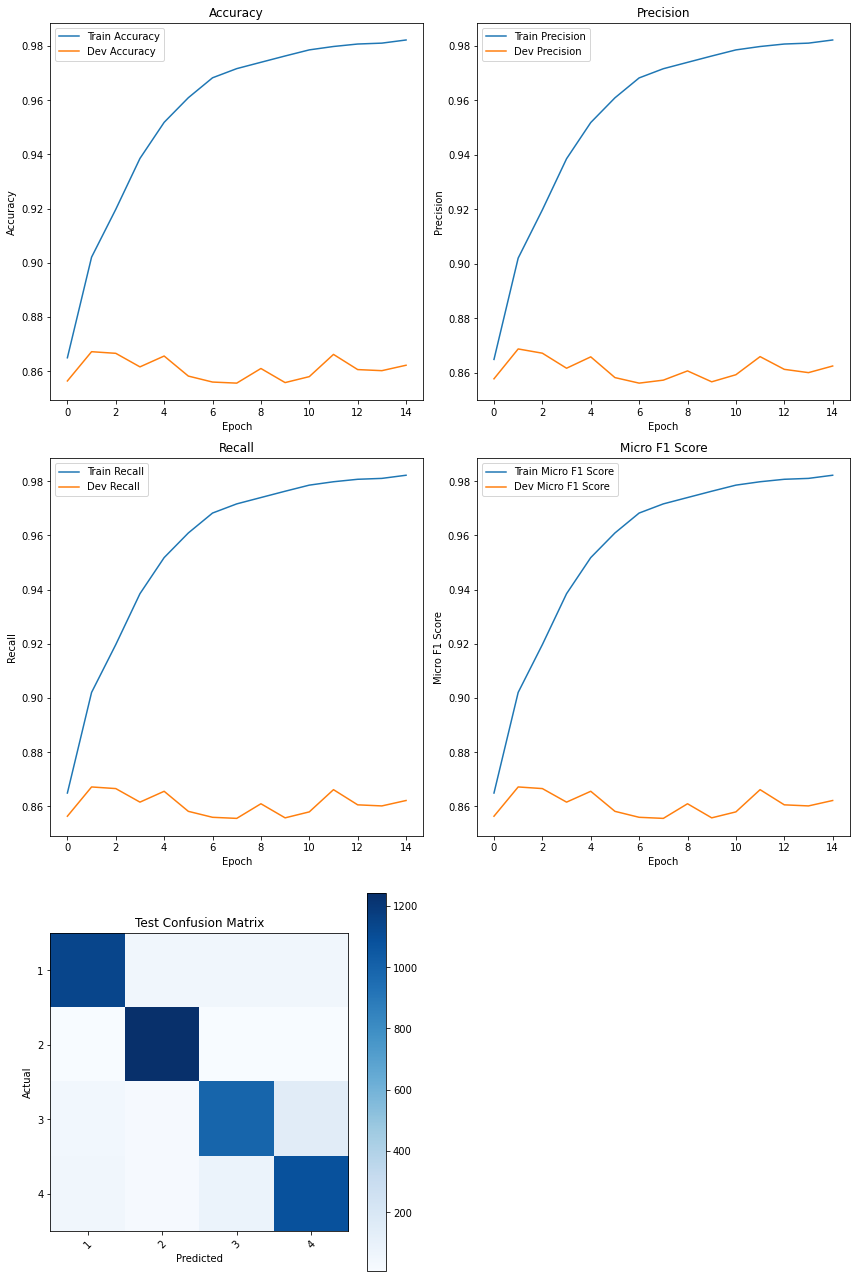

In [20]:
# Training hyperparameters
num_epochs = 15

# Initialize lists to store evaluation metrics for training, dev, and test
train_accuracy_values = []
train_precision_values = []
train_recall_values = []
train_micro_f1_values = []

dev_accuracy_values = []
dev_precision_values = []
dev_recall_values = []
dev_micro_f1_values = []

test_accuracy_values = []
test_precision_values = []
test_recall_values = []
test_micro_f1_values = []

# Initialize variables to store predicted and actual values
train_all_predicted = []
train_all_actual = []

dev_all_predicted = []
dev_all_actual = []

test_all_predicted = []
test_all_actual = []

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(elmo.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy, train_predicted, train_actual = train_elmo(elmo, train_loader, optimizer, criterion, device)

    # Calculate precision, recall, and micro F1 score for training
    train_precision = precision_score(train_actual, train_predicted, average='weighted')
    train_recall = recall_score(train_actual, train_predicted, average='weighted')
    train_micro_f1 = f1_score(train_actual, train_predicted, average='micro')

    # Store training evaluation metrics
    train_accuracy_values.append(train_accuracy)
    train_precision_values.append(train_precision)
    train_recall_values.append(train_recall)
    train_micro_f1_values.append(train_micro_f1)

    train_all_predicted.extend(train_predicted)
    train_all_actual.extend(train_actual)

    print(f"Epoch {epoch+1}/{num_epochs} (Train) - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2%}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, Micro F1 Score: {train_micro_f1:.4f}")

    # Validation on dev_loader
    dev_loss, dev_accuracy, dev_predicted, dev_actual = evaluate_elmo(elmo, dev_loader, criterion, device)

    # Calculate precision, recall, and micro F1 score for dev_loader
    dev_precision = precision_score(dev_actual, dev_predicted, average='weighted')
    dev_recall = recall_score(dev_actual, dev_predicted, average='weighted')
    dev_micro_f1 = f1_score(dev_actual, dev_predicted, average='micro')

    # Store dev evaluation metrics per epoch
    dev_accuracy_values.append(dev_accuracy)
    dev_precision_values.append(dev_precision)
    dev_recall_values.append(dev_recall)
    dev_micro_f1_values.append(dev_micro_f1)

    dev_all_predicted.extend(dev_predicted)
    dev_all_actual.extend(dev_actual)

    print(f"Epoch {epoch+1}/{num_epochs} (Dev) - Loss: {dev_loss:.4f}, Accuracy: {dev_accuracy:.2%}, Precision: {dev_precision:.4f}, Recall: {dev_recall:.4f}, Micro F1 Score: {dev_micro_f1:.4f}")

# Testing on test_loader after training
test_loss, test_accuracy, test_predicted, test_actual = evaluate_elmo(elmo, test_loader, criterion, device)

# Calculate precision, recall, and micro F1 score for test_loader
test_precision = precision_score(test_actual, test_predicted, average='weighted')
test_recall = recall_score(test_actual, test_predicted, average='weighted')
test_micro_f1 = f1_score(test_actual, test_predicted, average='micro')

# Store test evaluation metrics
test_accuracy_values.append(test_accuracy)
test_precision_values.append(test_precision)
test_recall_values.append(test_recall)
test_micro_f1_values.append(test_micro_f1)

test_all_predicted.extend(test_predicted)
test_all_actual.extend(test_actual)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Micro F1 Score: {test_micro_f1:.4f}")

# Plot evaluation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 18))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(range(num_epochs), train_accuracy_values, label="Train Accuracy")
plt.plot(range(num_epochs), dev_accuracy_values, label="Dev Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

# Precision plot
plt.subplot(3, 2, 2)
plt.plot(range(num_epochs), train_precision_values, label="Train Precision")
plt.plot(range(num_epochs), dev_precision_values, label="Dev Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision")
plt.legend()

# Recall plot
plt.subplot(3, 2, 3)
plt.plot(range(num_epochs), train_recall_values, label="Train Recall")
plt.plot(range(num_epochs), dev_recall_values, label="Dev Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall")
plt.legend()

# Micro F1 Score plot
plt.subplot(3, 2, 4)
plt.plot(range(num_epochs), train_micro_f1_values, label="Train Micro F1 Score")
plt.plot(range(num_epochs), dev_micro_f1_values, label="Dev Micro F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Micro F1 Score")
plt.title("Micro F1 Score")
plt.legend()

# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(test_all_actual, test_all_predicted)
plt.subplot(3, 2, 5)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(1, 5), rotation=45)
plt.yticks(tick_marks, range(1, 5))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Saving the Model

In [21]:
# Save the model to a file
torch.save(elmo.state_dict(), 'elmo_model.pth')

# Loading the Model

In [22]:
# Create an instance of the ELMo model
loaded_elmo = ELMo(vocab_size, embedding_dim, hidden_dim, batch_size, max_len, embedding_matrix, num_classes=num_classes)

# Load the pretrained model state
loaded_elmo.load_state_dict(torch.load('elmo_model.pth', map_location=device))  # 'device' should be set to the appropriate device

# Move the loaded model to the appropriate device
loaded_elmo.to(device)


ELMo(
  (embedding1): Embedding(81098, 100)
  (embedding2): Embedding(81098, 100)
  (lstm_forward1): LSTM(100, 100, batch_first=True)
  (lstm_forward2): LSTM(100, 100, batch_first=True)
  (lstm_backward1): LSTM(100, 100, batch_first=True)
  (lstm_backward2): LSTM(100, 100, batch_first=True)
  (linear_mode1): Linear(in_features=200, out_features=81098, bias=True)
  (linear_mode2): Linear(in_features=200, out_features=81098, bias=True)
  (final_linear): Linear(in_features=51200, out_features=4, bias=True)
)

In [23]:
print(loaded_elmo.weights_mode0)

Parameter containing:
tensor([0.0755, 0.1636, 0.1592], device='cuda:0', requires_grad=True)


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:00<00:00, 205.13it/s]


Weight Vector: [0.0972, 0.1431, 0.1445]
Test Loss: 0.5609, Test Accuracy: 88.96%, Precision: 0.8899, Recall: 0.8896, Micro F1 Score: 0.8896


100%|██████████| 157/157 [00:00<00:00, 170.98it/s]


Weight Vector: [0.33, 0.33, 0.33]
Test Loss: 1.2573, Test Accuracy: 88.68%, Precision: 0.8874, Recall: 0.8868, Micro F1 Score: 0.8868


100%|██████████| 157/157 [00:00<00:00, 189.87it/s]


Weight Vector: [0, 0.5, 0.5]
Test Loss: 1.8217, Test Accuracy: 89.14%, Precision: 0.8911, Recall: 0.8914, Micro F1 Score: 0.8914


100%|██████████| 157/157 [00:00<00:00, 190.44it/s]


Weight Vector: [0.5, 0.25, 0.25]
Test Loss: 1.2630, Test Accuracy: 86.62%, Precision: 0.8698, Recall: 0.8662, Micro F1 Score: 0.8662


100%|██████████| 157/157 [00:00<00:00, 183.51it/s]


Weight Vector: [0.1, 0.2, 0.7]
Test Loss: 8.5096, Test Accuracy: 63.54%, Precision: 0.8099, Recall: 0.6354, Micro F1 Score: 0.6354


100%|██████████| 157/157 [00:00<00:00, 193.38it/s]


Weight Vector: [0.4, 0.4, 0.2]
Test Loss: 3.7248, Test Accuracy: 71.22%, Precision: 0.7732, Recall: 0.7122, Micro F1 Score: 0.7122


100%|██████████| 157/157 [00:00<00:00, 190.66it/s]


Weight Vector: [0.6, 0.2, 0.2]
Test Loss: 1.4803, Test Accuracy: 83.18%, Precision: 0.8406, Recall: 0.8318, Micro F1 Score: 0.8318


100%|██████████| 157/157 [00:00<00:00, 194.98it/s]


Weight Vector: [0.1, 0.3, 0.6]
Test Loss: 3.6110, Test Accuracy: 79.82%, Precision: 0.8487, Recall: 0.7982, Micro F1 Score: 0.7982


100%|██████████| 157/157 [00:00<00:00, 191.07it/s]


Weight Vector: [0.15, 0.15, 0.7]
Test Loss: 10.9368, Test Accuracy: 58.06%, Precision: 0.8050, Recall: 0.5806, Micro F1 Score: 0.5806


100%|██████████| 157/157 [00:00<00:00, 192.82it/s]


Weight Vector: [0.1, 0.7, 0.2]
Test Loss: 20.7362, Test Accuracy: 43.06%, Precision: 0.7671, Recall: 0.4306, Micro F1 Score: 0.4306


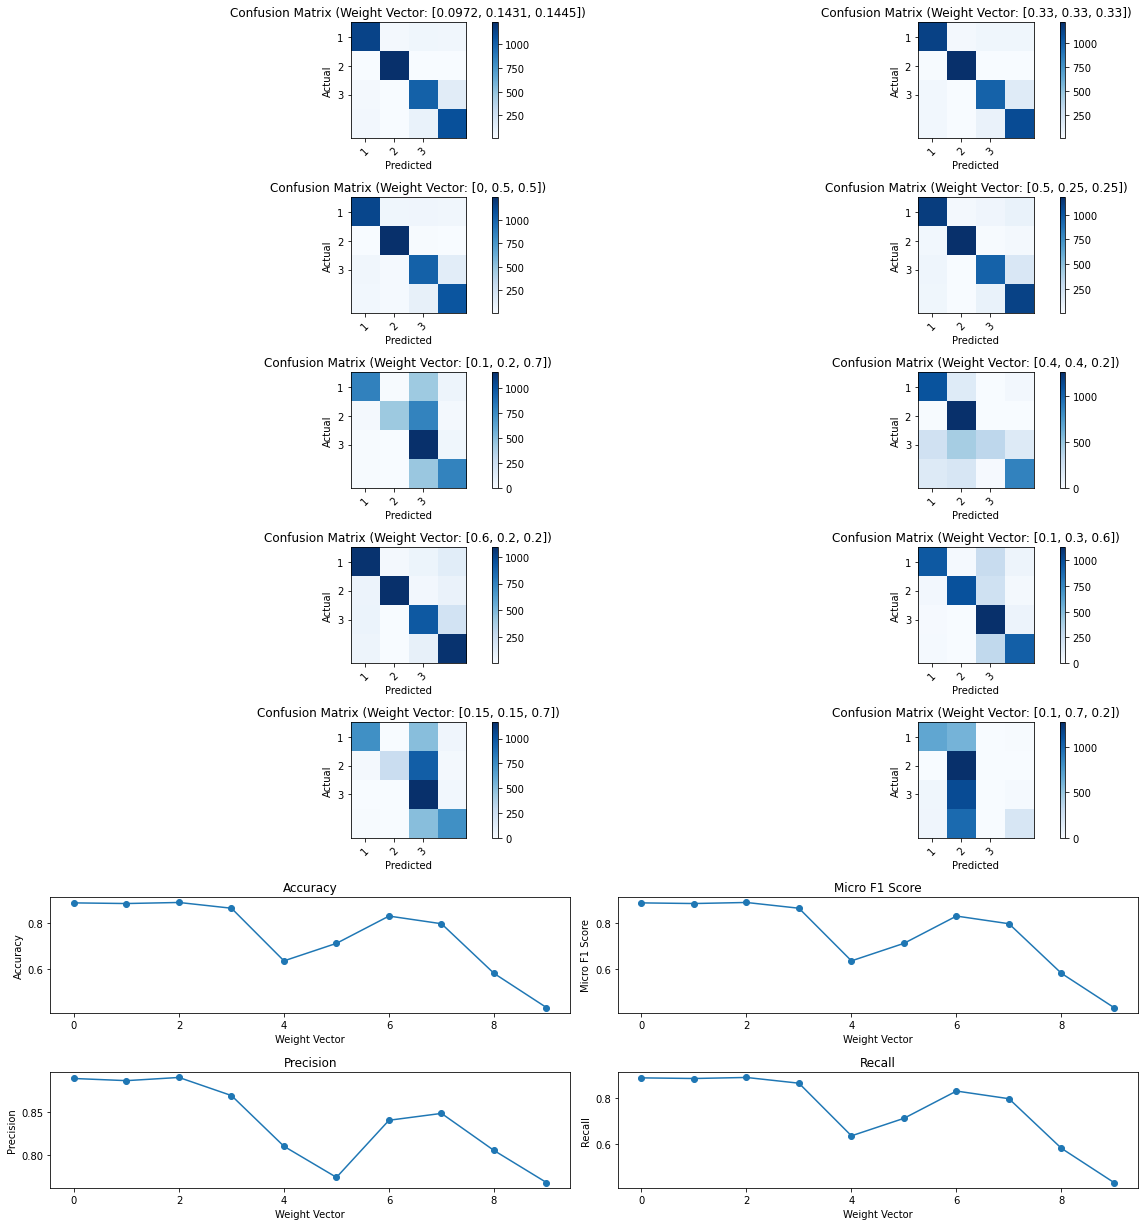

In [24]:
# Define a list of weight vectors
weight_vectors = [
    [0.0972, 0.1431, 0.1445],
    [0.33, 0.33, 0.33],
    [0, 0.5, 0.5],
    [0.5, 0.25, 0.25],
    [0.1, 0.2, 0.7],
    [0.4, 0.4, 0.2],
    [0.6, 0.2, 0.2],
    [0.1, 0.3, 0.6],
    [0.15, 0.15, 0.7],
    [0.1, 0.7, 0.2]
]

# Initialize lists to store evaluation metrics
accuracy_values = []
precision_values = []
recall_values = []
micro_f1_values = []

# Initialize variables to store predicted and actual values
all_predicted = []
all_actual = []

# Initialize a subplot counter for confusion matrices
subplot_counter = 1

# Create a figure for confusion matrices and evaluation metrics with increased height
plt.figure(figsize=(16, 24))  # Increased height

# Iterate through each weight vector
for weights in weight_vectors:
    # Create a torch.nn.Parameter from the weight vector and set it in the model
    weight_parameter = nn.Parameter(torch.tensor(weights, device=device, dtype=torch.float32, requires_grad=True))
    loaded_elmo.weights_mode0 = weight_parameter

    # Testing on test_loader after training
    test_loss, test_accuracy, test_predicted, test_actual = evaluate_elmo(loaded_elmo, test_loader, criterion, device)

    # Calculate precision, recall, and micro F1 score for test_loader
    test_precision = precision_score(test_actual, test_predicted, average='weighted')
    test_recall = recall_score(test_actual, test_predicted, average='weighted')
    test_micro_f1 = f1_score(test_actual, test_predicted, average='micro')

    # Store test evaluation metrics
    accuracy_values.append(test_accuracy)
    precision_values.append(test_precision)
    recall_values.append(test_recall)
    micro_f1_values.append(test_micro_f1)

    # Store predicted and actual values for confusion matrix
    all_predicted.extend(test_predicted)
    all_actual.extend(test_actual)

    # Print evaluation metrics for the current weight vector
    print(f"Weight Vector: {weights}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Micro F1 Score: {test_micro_f1:.4f}")

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(test_actual, test_predicted)

    # Create a subplot for the confusion matrix with increased height
    plt.subplot(len(weight_vectors), 2, subplot_counter)
    subplot_counter += 1

    # Display confusion matrix
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Weight Vector: {weights})')
    plt.colorbar()
    tick_marks = np.arange(len(weights))
    plt.xticks(tick_marks, range(1, len(weights) + 1), rotation=45)  # Adjust the labels based on the number of classes
    plt.yticks(tick_marks, range(1, len(weights) + 1))  # Adjust the labels based on the number of classes
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# Plot the evaluation metrics (accuracy, micro F1, precision, and recall) with increased height
plt.subplot(len(weight_vectors), 2, subplot_counter)
subplot_counter += 1

# Accuracy plot
plt.plot(range(len(weight_vectors)), accuracy_values, marker='o')
plt.xlabel("Weight Vector")
plt.ylabel("Accuracy")
plt.title("Accuracy")

# Micro F1 Score plot
plt.subplot(len(weight_vectors), 2, subplot_counter)
subplot_counter += 1
plt.plot(range(len(weight_vectors)), micro_f1_values, marker='o')
plt.xlabel("Weight Vector")
plt.ylabel("Micro F1 Score")
plt.title("Micro F1 Score")

# Precision plot
plt.subplot(len(weight_vectors), 2, subplot_counter)
subplot_counter += 1
plt.plot(range(len(weight_vectors)), precision_values, marker='o')
plt.xlabel("Weight Vector")
plt.ylabel("Precision")
plt.title("Precision")

# Recall plot
plt.subplot(len(weight_vectors), 2, subplot_counter)
plt.plot(range(len(weight_vectors)), recall_values, marker='o')
plt.xlabel("Weight Vector")
plt.ylabel("Recall")
plt.title("Recall")

plt.tight_layout()
plt.show()